## Importing Relevant Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import PIL.Image as image
import pathlib
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

In [2]:
photo_dir='./celeb_photos'

In [3]:
photo_dir=pathlib.Path(photo_dir)
photo_dir

WindowsPath('celeb_photos')

In [4]:
phs=list(photo_dir.glob('*/*'))

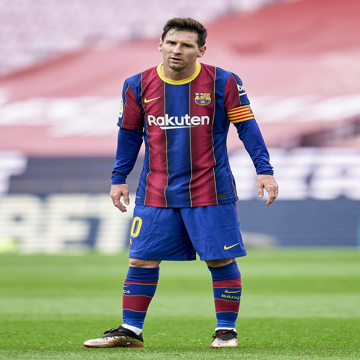

In [5]:
image.open(str(phs[90])).resize((360,360))

## Creating dictionaries for the images and their labels

In [6]:
images_dict={
    'messi':list(photo_dir.glob('messi/*')),
    'kohli':list(photo_dir.glob('virat_kohli/*')),
    'ronaldo':list(photo_dir.glob('ronaldo/*')),
    'vettel':list(photo_dir.glob('vettel/*')),
    'PV Sindhu':list(photo_dir.glob('pv_sindhu/*')),
}

In [7]:
photo_labels={
    'messi':0,
    'kohli':1,
    'ronaldo':2,
    'vettel':3,
    'PV Sindhu':4,
}

## Splitting data intoTrain and Test

In [55]:
x,y=[],[]

for celeb_name,celeb_images in images_dict.items():
    for img in celeb_images:
        image=cv2.imread(str(img))
        try:
            resized=cv2.resize(image,(360,360))
        except:
            continue
        x.append(resized)
        y.append(photo_labels[celeb_name])

In [56]:
x=np.array(x)
y=np.array(y)

In [41]:
from sklearn.utils import shuffle
X=shuffle(x)

In [57]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [58]:
x_train_scaled=x_train/255.0
x_test_scaled=x_test/255.0

In [59]:
x_train.shape

(357, 360, 360, 3)

In [60]:
y_train.shape

(357,)

## Using Transfer learning to train the model

In [61]:
feature_vector="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [62]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(360,360,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

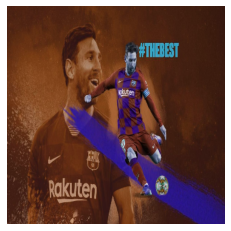

In [63]:
plt.imshow(x[0])
plt.axis('off')
plt.show()

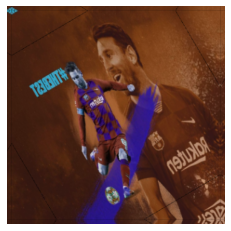

In [64]:
plt.imshow(data_augmentation(x)[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()

In [65]:
resnet=tf.keras.Sequential([
    data_augmentation,
    hub.KerasLayer(feature_vector,input_shape=(360,360,3),trainable=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5)
])

In [66]:
resnet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 360, 360, 3)       0         
_________________________________________________________________
keras_layer_2 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [67]:
resnet.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

In [68]:
resnet.fit(x_train_scaled,y_train,epochs=10,validation_split=0.2)

Epoch 1/10
9/9 [==============================] - 56s 6s/step - loss: 2.0895 - acc: 0.1789 - val_loss: 1.6666 - val_acc: 0.2222
Epoch 2/10
9/9 [==============================] - 57s 6s/step - loss: 1.7283 - acc: 0.2632 - val_loss: 1.3515 - val_acc: 0.4444
Epoch 3/10
9/9 [==============================] - 55s 6s/step - loss: 1.4138 - acc: 0.4316 - val_loss: 1.1656 - val_acc: 0.6528
Epoch 4/10
9/9 [==============================] - 54s 6s/step - loss: 1.2270 - acc: 0.5088 - val_loss: 1.0705 - val_acc: 0.6250
Epoch 5/10
9/9 [==============================] - 54s 6s/step - loss: 1.1370 - acc: 0.5719 - val_loss: 0.9414 - val_acc: 0.7083
Epoch 6/10
9/9 [==============================] - 54s 6s/step - loss: 0.9753 - acc: 0.6526 - val_loss: 0.8832 - val_acc: 0.7361
Epoch 7/10
9/9 [==============================] - 55s 6s/step - loss: 0.9682 - acc: 0.6316 - val_loss: 0.8338 - val_acc: 0.7917
Epoch 8/10
9/9 [==============================] - 59s 7s/step - loss: 0.8615 - acc: 0.6842 - val_loss: 0

In [69]:
resnet.evaluate(x_test_scaled,y_test)

4/4 [==============================] - 14s 3s/step - loss: 0.7685 - acc: 0.7815


[0.7685386538505554, 0.7815126180648804]

## Predictions

In [70]:
preds=resnet.predict(x_test_scaled)

In [71]:
preds

array([[-9.07507420e-01, -1.06381118e+00,  8.51407349e-01,
        -4.46646482e-01, -1.50970602e+00],
       [-1.67761669e-01, -7.96896577e-01, -7.38259733e-01,
        -1.52012718e+00, -1.83422208e+00],
       [-3.10765004e+00, -2.50610685e+00, -1.93072784e+00,
         9.70662177e-01, -2.87598920e+00],
       [-1.43038762e+00, -7.38211274e-01, -1.42519403e+00,
         2.25164914e+00, -2.66713214e+00],
       [-6.74420786e+00, -1.81473899e+00, -1.43704402e+00,
         5.72871983e-01, -1.31789851e+00],
       [-2.19457293e+00, -5.26295543e-01, -1.70004416e+00,
        -1.06414402e+00, -3.54027927e-01],
       [-5.20099759e-01, -1.24291599e+00, -1.33481741e+00,
        -1.00098860e+00, -1.42955303e+00],
       [ 5.87000251e-01, -1.96432698e+00, -2.06900430e+00,
         1.64851952e+00, -1.69256830e+00],
       [ 1.14549220e+00, -7.93032527e-01, -6.29121065e-01,
        -1.44425726e+00, -1.56396151e+00],
       [-2.04756832e+00, -2.79756904e+00, -1.18720675e+00,
        -2.28640079e+00

In [72]:
y_pred=[np.argmax(i) for i in preds]

In [73]:
classes=['messi','kohli','ronaldo','vettel','sindhu']

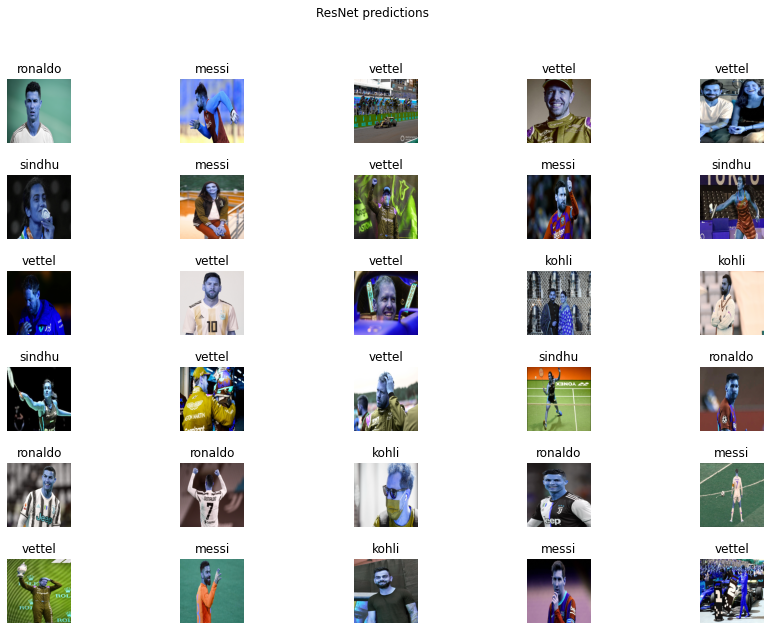

In [74]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(x_test_scaled[n])
    plt.title(classes[y_pred[n]])
    plt.axis('off')
    plt.suptitle("ResNet predictions")

## Confusion matrix

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

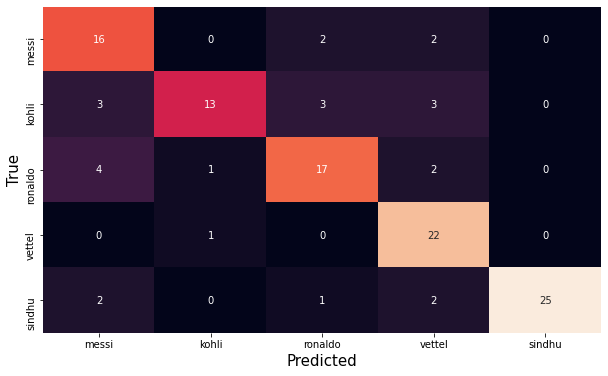

In [76]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,xticklabels=classes,yticklabels=classes,cbar=False)
plt.xlabel('Predicted', size=15)
plt.ylabel('True', size=15)
plt.show()

## Classification Report

In [77]:
from sklearn.metrics import classification_report

In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.80      0.71        20
           1       0.87      0.59      0.70        22
           2       0.74      0.71      0.72        24
           3       0.71      0.96      0.81        23
           4       1.00      0.83      0.91        30

    accuracy                           0.78       119
   macro avg       0.79      0.78      0.77       119
weighted avg       0.81      0.78      0.78       119

